In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.mlab as mlab
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import math
import seaborn as sns
from six.moves import cPickle as pickle
import csv
import sys
import pandas as pd
import time

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy import stats

import matplotlib.lines as mlines
import re
from scipy import optimize

import matplotlib.colors as colors2
import matplotlib.cm as cmx

import numpy.polynomial.polynomial as poly

from sklearn import linear_model

from scipy.interpolate import interp1d

from pyemd import emd
# https://github.com/wmayner/pyemd
# Ofir Pele and Michael Werman, "Fast and robust earth mover's distances," in Proc. 2009 IEEE 
# 12th Int. Conf. on Computer Vision, Kyoto, Japan, 2009, pp. 460-467.

from multiprocessing import Pool

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, 'grid.linewidth': 0.})


In [3]:
# load the data
consumption_df = pd.read_pickle('../cleanedLoadData/consumption_df_round3.pickle')

In [4]:
len(consumption_df)

255

In [5]:
consumption_df.head()

,user_id,cities,states,2015-01-01 00:00:00,2015-01-01 00:15:00,2015-01-01 00:30:00,2015-01-01 00:45:00,2015-01-01 01:00:00,2015-01-01 01:15:00,2015-01-01 01:30:00,...,2015-12-31 21:30:00,2015-12-31 21:45:00,2015-12-31 22:00:00,2015-12-31 22:15:00,2015-12-31 22:30:00,2015-12-31 22:45:00,2015-12-31 23:00:00,2015-12-31 23:15:00,2015-12-31 23:30:00,2015-12-31 23:45:00
1,3935,Austin,Texas,0.327,0.230,0.224,0.222,0.199,0.189,0.188,...,0.180,0.213,0.203,0.220,0.229,0.179,0.0,0.0,0.0,0.0
2,668,Austin,Texas,0.380,0.270,0.246,0.193,0.204,0.215,0.219,...,0.095,0.060,0.060,0.079,0.117,0.089,0.0,0.0,0.0,0.0
3,6412,Austin,Texas,0.484,0.329,0.292,0.222,0.215,0.220,0.230,...,0.223,0.194,0.233,0.223,0.203,0.215,0.0,0.0,0.0,0.0
4,5814,Austin,Texas,0.369,0.235,0.047,0.096,0.093,0.028,0.027,...,0.114,0.113,0.113,0.095,0.091,0.091,0.0,0.0,0.0,0.0
5,8046,Austin,Texas,0.169,0.131,0.093,0.072,0.087,0.072,0.088,...,0.183,0.190,0.181,0.176,0.290,0.251,0.0,0.0,0.0,0.0


In [6]:
len(consumption_df.user_id.unique())

255

In [7]:
cIDs = consumption_df.user_id.unique()

In [8]:
consumption_df = consumption_df.set_index('user_id')

In [9]:
min15_df = consumption_df.iloc[:,2:]

In [10]:
min15Vals = min15_df.iloc[:,:].values

In [12]:
# change the vals to hourly
[a,b] = np.shape(min15Vals)
hourlyVals = np.zeros((a,np.int(b/4)))
for j in range(np.int(b/4)):
    hourlyVals[:,j] = np.sum(min15Vals[:,j*4+0:(j+1)*4], axis=1)

In [13]:
# make an hourly dataframe
colsT = pd.date_range(start='1/1/2015', end='1/1/2016', freq='1H')[0:-1]
print(len(colsT))
hourly_df = pd.DataFrame(hourlyVals, index=np.arange(a), columns=colsT)

8760


In [14]:
hourly_df['user_id'] = cIDs

In [15]:
hourly_df = hourly_df.set_index('user_id')

In [16]:
# first lets look at the consumption data - aggregate plus a couple of individual
aggregateLoad = hourly_df.sum(axis=0)

In [17]:
hourly_df.head()

,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
3935,1.003,0.764,0.868,0.171,0.273,0.212,0.353,0.706,0.790,0.919,...,0.804,0.367,0.568,0.665,0.939,0.688,0.427,0.756,0.831,0.0
668,1.089,0.832,0.828,0.772,0.819,0.798,0.808,0.881,1.866,2.884,...,1.066,0.478,0.489,0.524,1.167,1.016,0.594,0.306,0.345,0.0
6412,1.327,0.831,0.838,0.818,0.751,1.536,1.358,1.006,1.797,5.177,...,0.521,0.599,0.839,1.471,1.523,1.411,1.300,0.873,0.874,0.0
5814,0.747,0.175,0.255,0.269,0.193,0.276,0.265,0.169,0.708,0.691,...,0.190,0.367,0.421,0.455,1.016,0.825,0.459,0.479,0.390,0.0
8046,0.465,0.339,0.318,0.528,1.262,1.297,1.354,1.603,2.131,2.314,...,0.525,0.526,1.002,0.892,0.830,0.880,0.838,0.800,0.898,0.0


Text(0, 0.5, '# of users')

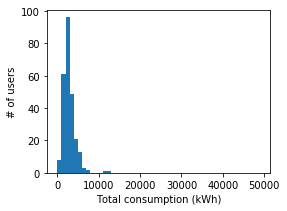

In [18]:
# plot a histogram of consumption
consTotal = hourly_df.sum(axis=1).values/4
consBins = np.arange(0,50000,1000)
consHist, consEdges = np.histogram(consTotal, consBins, density=False)
widths = consEdges[1:]-consEdges[0:-1]
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
ax1.bar(consEdges[0:-1]+widths/2,consHist,width=widths)
ax1.set_xlabel('Total consumption (kWh)')
ax1.set_ylabel('# of users')

* the weather data is in UTC!

In [31]:
# load in the temperature data
weatherFile2015 = '../weatherData/CRNH0203-2015-TX_Austin_33_NW.txt'
weatherFile2016 = '../weatherData/CRNH0203-2016-TX_Austin_33_NW.txt'

hourlyTemp = np.zeros((8760))
with open(weatherFile2015, 'rb') as inFile:
    lineCount = 0
    for line in inFile:
        line = line.decode('utf-8')
        if lineCount>=6:
            hourlyTemp[lineCount-6] = re.sub('\s+',',',line.strip()).split(',')[9]
            if lineCount == 6:
                print(line)
        lineCount+=1
        
print(lineCount)
        
with open(weatherFile2016, 'rb') as inFile:
    for line in inFile:
        line = line.decode('utf-8')
        hourlyTemp[lineCount-6] = re.sub('\s+',',',line.strip()).split(',')[9]
        lineCount+=1
        if lineCount-6>=8760:
            break

23907 20150101 0700 20150101 0100  2.423  -98.08   30.62     0.2     0.3     0.4     0.2     0.0      0 0      0 0      0 0 C     2.6 0     2.7 0     2.5 0    88 0   0.327   0.287 -99.000 -99.000 -99.000     7.2     8.5 -9999.0 -9999.0 -9999.0

8760


In [32]:
hourlyTemp[-10:]

array([9.6, 9.2, 8.6, 8.3, 8. , 7.8, 7.7, 7.6, 7.3, 7. ])

In [34]:
# strip out values where == -9999
missingLabel = min(hourlyTemp)
print(len(np.where(hourlyTemp==missingLabel)[0]))
badIndices = np.where(hourlyTemp==missingLabel)[0]

61


In [35]:
def get_interp_windows(badIndices):
    windows = []
    considered = np.ones((len(badIndices)))
    j=0
    while any(considered==1):
        #print j
        # consider +- 10 hours
        lowerLimit = badIndices[j]-10
        offset = 1

        # add in if len to stop err
        if j<len(considered)-1:
            while badIndices[j+offset] == badIndices[j]+offset:
                offset+=1
            upperLimit = badIndices[j]+offset+9
            # find the next j
            considered[j:j+offset]=0
            j = j+offset
        else:
            considered[j]=0
            upperLimit = badIndices[j]+offset+9
        windows.append([lowerLimit,upperLimit])
    return windows

In [36]:
interpWindows = get_interp_windows(badIndices)
print(interpWindows)

[[1469, 1491], [1503, 1532], [3481, 3501], [3805, 3838], [3915, 3943], [3967, 3992], [4010, 4034], [4016, 4036], [4031, 4053], [7062, 7083], [7319, 7339], [7535, 7558], [7658, 7678], [8187, 8207]]


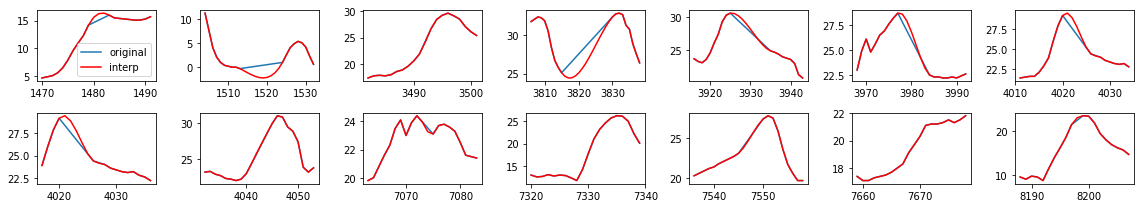

In [38]:
# now lets interpolate to get missing temperature values
timePlot = np.arange(1,len(hourlyTemp)+1)
hourlyTemp[badIndices]=np.nan
hourlyTempInterp = np.copy(hourlyTemp)
fig = plt.figure(figsize=(16,3)) # there are 14 windows
axs = []
for j in range(len(interpWindows)):
    axs.append(fig.add_subplot(len(interpWindows)/7,7,j+1))

for j,window in enumerate(interpWindows):
    test = hourlyTemp[window[0]:window[1]]
    timeWindow = timePlot[window[0]:window[1]]
    hours = timeWindow[~np.isnan(test)]
    test = test[~np.isnan(test)]
    # now let's interp this
    f1 = interp1d(hours, test, kind='cubic')
    # now include the interp values
    hourlyTempInterp[window[0]:window[1]] = f1(timeWindow)
    
    l1, = axs[j].plot(hours,test)
    l2, = axs[j].plot(timeWindow,hourlyTempInterp[window[0]:window[1]],color='r')
    
axs[0].legend([l1,l2],['original','interp'])
fig.tight_layout()

In [39]:
hourlyTemp = hourlyTempInterp

In [40]:
np.savetxt('../weatherData/hourlyTempCleaned.csv', hourlyTemp, delimiter=',')

In [41]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*(x-x0)+y0, lambda x:k2*(x-x0)+y0])

In [42]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
          'November', 'December']
daynum = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [43]:
np.sum(daynum[0:13])

365

/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


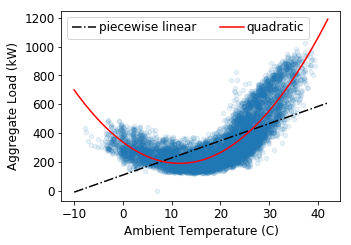

In [44]:
fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
ax1.scatter(hourlyTemp,hourly_df.sum(axis=0),marker='o',s=20,alpha=0.1)
p , e = optimize.curve_fit(piecewise_linear, hourlyTemp,hourly_df.sum(axis=0))
#print ['%.2f'%e for e in p]
xd = np.linspace(-10,42,101)
ax1.plot(xd, piecewise_linear(xd, *p), color='k', linestyle='-.')
coefs = poly.polyfit(hourlyTemp, hourly_df.sum(axis=0), 2)
#print coefs
ffit = poly.polyval(xd, coefs)

ax1.plot(xd, ffit, color='r')

ax1.set_xlabel('Ambient Temperature (C)', fontsize=12)
ax1.set_ylabel('Aggregate Load (kW)', fontsize=12)

ax1.tick_params(axis='both', labelsize=12)

proxys = [ ]
proxys.append( mlines.Line2D([], [], color='k', linestyle='-.') )
proxys.append( mlines.Line2D([], [], color='r', linestyle='-') )

plt.legend(proxys, ['piecewise linear','quadratic'],\
           ncol=2, fontsize=12, handletextpad=0.2)
# fig.savefig('../outputs/Temperature_hourlyload_predictor.png', dpi=300, format='png',  bbox_inches='tight')

Look at temperture in different months at different time periods <br>
**Both piecewise and third order polynominals are typically used for the load-temperature relationship. <br>

In [45]:
nightTime = np.asarray([23,0,1,2,3,4])
earlyMorn = np.asarray([5,6,7,8])
dayTime = np.asarray([9,10,11,12,13,14,15])
eveningTime = np.asarray([16,17,18,19,20,21,22,23])
timeLists = [nightTime, earlyMorn, dayTime, eveningTime]
lineStyles = ['-','-.',':','--']

In [47]:
##### lets train on data up until September
startTrain = np.int(np.sum(daynum[0:months.index('January')])*24)
endTrain = np.int(np.sum(daynum[0:months.index('September')])*24)

#####
# get all new features
startPred = np.int(np.sum(daynum[0:months.index('September')])*24)
endPred = np.int(np.sum(daynum[0:months.index('November')])*24)
lenPrediction = endPred-startPred
print('The training length = %d hours'%(endTrain-startTrain))
print('The prediction length = %d hours'%lenPrediction)

featureLength = endPred-(startTrain+168) # we need to train on 24 hours behind

The training length = 5832 hours
The prediction length = 1464 hours


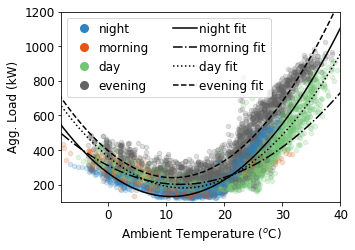

In [50]:
#create colormap
minVal, maxVal = 1, 24.
cmOcc = plt.cm.get_cmap('tab20c')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

fig = plt.figure(figsize=(5,3.5))
nDays = np.int((endTrain-startTrain)/24)
hourlyTempReshape = hourlyTemp[startTrain:endTrain].reshape(nDays,24)
loadReshape = (aggregateLoad[startTrain:endTrain].values).reshape(nDays,24)
ax1 = fig.add_subplot(111)
for k in range(24):
    #cl = scalarMap3.to_rgba((np.float(k+1)))
    if k in nightTime:
        cl = scalarMap3.to_rgba((1))
    elif k in earlyMorn:
        cl = scalarMap3.to_rgba((6))
    elif k in dayTime:
        cl = scalarMap3.to_rgba((12))
    elif k in eveningTime:
        cl = scalarMap3.to_rgba((20))

    else:
        print('Oops')
    cl = colors2.rgb2hex(cl)
    ax1.scatter(hourlyTempReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.2, color=cl)

colorIndex = [1,6,12,20]
colorsO = []
############ FIT POLYNOMIAL AT EACH TIME BLOCK ##########
for k in range(4):
    coefs = poly.polyfit(hourlyTempReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 2)
    ffit = poly.polyval(xd, coefs)
    plt.plot(xd, ffit, color='k', linestyle=lineStyles[k])
    cl = scalarMap3.to_rgba((colorIndex[k]))
    colorsO.append(colors2.rgb2hex(cl))

ax1.set_xlabel('Ambient Temperature ($^o$C)', fontsize=12)
ax1.set_ylabel('Agg. Load (kW)', fontsize=12)
ax1.set_ylim([100,1200])
ax1.set_xlim([np.floor(np.min(hourlyTempReshape)),np.ceil(np.max(hourlyTempReshape))])
ax1.tick_params(axis='both', labelsize=12)

proxys = [ plt.plot([],[], marker="o", ms=8, ls="", mec=None, color=colorsO[i])[0] for i in range(4) ]
for k in range(4):
    proxys.append( mlines.Line2D([], [], color='k', linestyle=lineStyles[k]) )

plt.legend(proxys, ['night', 'morning', 'day', 'evening', 'night fit', 'morning fit', 'day fit', 'evening fit'],\
           ncol=2, numpoints=1, fontsize=12, handletextpad=0.2)
# fig.savefig('../outputs/Temperature_hourlyload.png', dpi=300, format='png',  bbox_inches='tight')

In [51]:
# colors

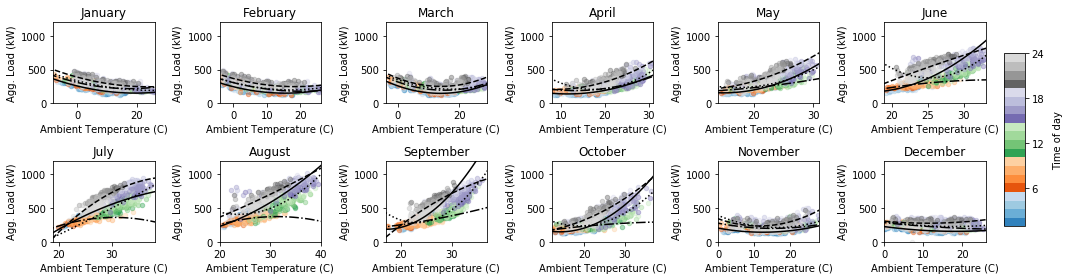

In [52]:
#create colormap
minVal, maxVal = 1, 24.
cmOcc = plt.cm.get_cmap('tab20c')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

fig = plt.figure(figsize=(14,4))
for j in range(len(months)):
    start = np.int(np.sum(daynum[0:j])*24)
    end = np.int(np.sum(daynum[0:j+1])*24)
    #hourlyTempFirst, hourlyTempSecond = np.zeros(((end-start)/2)), np.zeros(((end-start)/2))
    nDays = np.int((end-start)/24)
    hourlyTempReshape = hourlyTemp[start:end].reshape(nDays,24)
    loadReshape = (aggregateLoad[start:end].values).reshape(nDays,24)

    ax1 = fig.add_subplot(2,6,j+1)
    for k in range(24):
        cl = scalarMap3.to_rgba((np.float(k+1)))
        cl = colors2.rgb2hex(cl)
        ax1.scatter(hourlyTempReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.4, color=cl)  
        
    ############ FIT POLYNOMIAL AT EACH TIME BLOCK ##########
    for k in range(4):
        coefs = poly.polyfit(hourlyTempReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 2)
        ffit = poly.polyval(xd, coefs)
        plt.plot(xd, ffit, color='k', linestyle=lineStyles[k])
    
    ax1.set_xlabel('Ambient Temperature (C)')
    ax1.set_ylabel('Agg. Load (kW)')
    ax1.set_title(months[j])
    ax1.set_ylim([0,1200])
    ax1.set_xlim([np.floor(np.min(hourlyTempReshape)),np.ceil(np.max(hourlyTempReshape))])
fig.tight_layout()

cbar_ax = plt.axes([1, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,24.1,6), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major')
cbar.set_label('Time of day', labelpad=9, rotation=90)

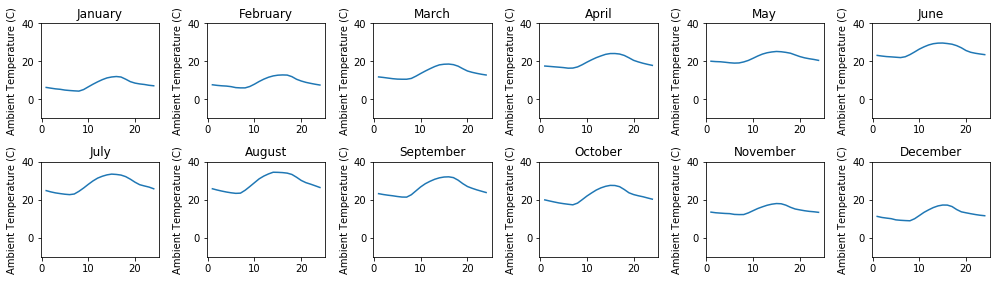

In [53]:
# plot average monthly temperature profile
fig = plt.figure(figsize=(14,4))
for j in range(len(months)):
    start = np.int(np.sum(daynum[0:j])*24)
    end = np.int(np.sum(daynum[0:j+1])*24)
    nDays = np.int((end-start)/24)
    hourlyTempReshape = hourlyTemp[start:end].reshape(nDays,24)
    ax1 = fig.add_subplot(2,6,j+1)
    ax1.plot(np.arange(1,24.1), np.mean(hourlyTempReshape, axis=0))
    ax1.set_ylabel('Ambient Temperature (C)')
    ax1.set_title(months[j])
    ax1.set_ylim([-10,40])
fig.tight_layout()

We can see that at different times of day the relationship between temperature and load is different <br>
It is also different in different months in the year <br>
** possibly suggests that we should try splitting by: ** <br> 
* ** HEAT: Jan,Feb,Mar. FLAT: Nov,Dec. COOL:Jun,Jul,Aug, Jun-Sept. lowCOOL: Apr,May,Oct ** <br>
* ** by Time of Day **

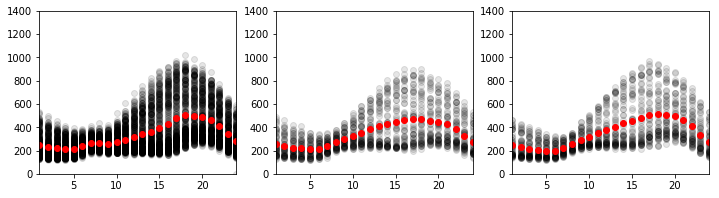

In [54]:
# plot weekdays, sat and sun all aggregate consumption
fig = plt.figure(figsize=(12,3))
axs = []
for j in range(3):
    axs.append( fig.add_subplot(1,3,j+1))
    
start = 0
end = 24
weekdays, saturdays, sundays = [], [], []
for j in range(365):
    dayConsumption = aggregateLoad[start:end]
    # get the day of week
    day_of_week = dayConsumption.index[0]
    day_of_week = day_of_week.dayofweek
    if day_of_week in [0,1,2,3,4]:
        axs[0].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        weekdays.append(dayConsumption)
    elif day_of_week in [5]:
        axs[1].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        saturdays.append(dayConsumption)
    else:
        axs[2].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        sundays.append(dayConsumption)
    start+=24
    end+=24
for ax in axs:
    ax.set_xlim([1,24])
    ax.set_ylim([0,1400])

axs[0].scatter(np.arange(1,25),np.mean(weekdays, axis=0),color='r')
axs[1].scatter(np.arange(1,25),np.mean(saturdays, axis=0),color='r')
axs[2].scatter(np.arange(1,25),np.mean(sundays, axis=0),color='r')

#### For an individual  household

In [55]:
randIDs = []
for j in range(15):
    uID = hourly_df.index.values[np.random.randint(len(hourly_df))]
    randIDs.append(uID)

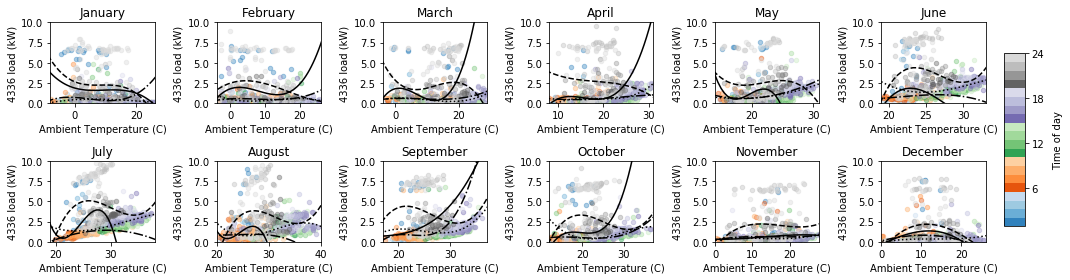

In [56]:
uID = randIDs[6]
fig = plt.figure(figsize=(14,4))
for j in range(len(months)):
    start = np.int(np.sum(daynum[0:j])*24)
    end = np.int(np.sum(daynum[0:j+1])*24)
    nDays = np.int((end-start)/24)
    hourlyTempReshape = hourlyTemp[start:end].reshape(nDays,24)
    loadReshape = hourly_df.loc[uID][start:end]
    loadReshape = (loadReshape.values).reshape(nDays,24)

    ax1 = fig.add_subplot(2,6,j+1)
    for k in range(24):
        cl = scalarMap3.to_rgba((np.float(k+1)))
        cl = colors2.rgb2hex(cl)
        ax1.scatter(hourlyTempReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.4, color=cl)   
        
    ############ FIT POLYNOMIAL AT EACH TIME BLOCK ##########
    for k in range(4):
        coefs = poly.polyfit(hourlyTempReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 3)
        ffit = poly.polyval(xd, coefs)
        plt.plot(xd, ffit, color='k', linestyle=lineStyles[k])
            
    ax1.set_xlim([np.floor(np.min(hourlyTempReshape)),np.ceil(np.max(hourlyTempReshape))])
    ax1.set_ylim([0,10])
    ax1.set_xlabel('Ambient Temperature (C)')
    str111 = '%d load (kW)'%uID
    ax1.set_ylabel(str111)
    ax1.set_title(months[j])
fig.tight_layout()

cbar_ax = plt.axes([1, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,24.1,6), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major')
cbar.set_label('Time of day', labelpad=9, rotation=90)

In [57]:
# # restrict for only looking at certain months?
# start = np.int(np.sum(daynum[0:months.index('January')])*24)
# end = np.int(np.sum(daynum[0:months.index('December')])*24)
# end = 8760
# print(start, end)

In [58]:
# hourly_df = hourly_df.iloc[:,start:end]
# hourlyTemp = hourlyTemp[start:end]

In [59]:
# hourly_df.head()

### Look at some random households in random months

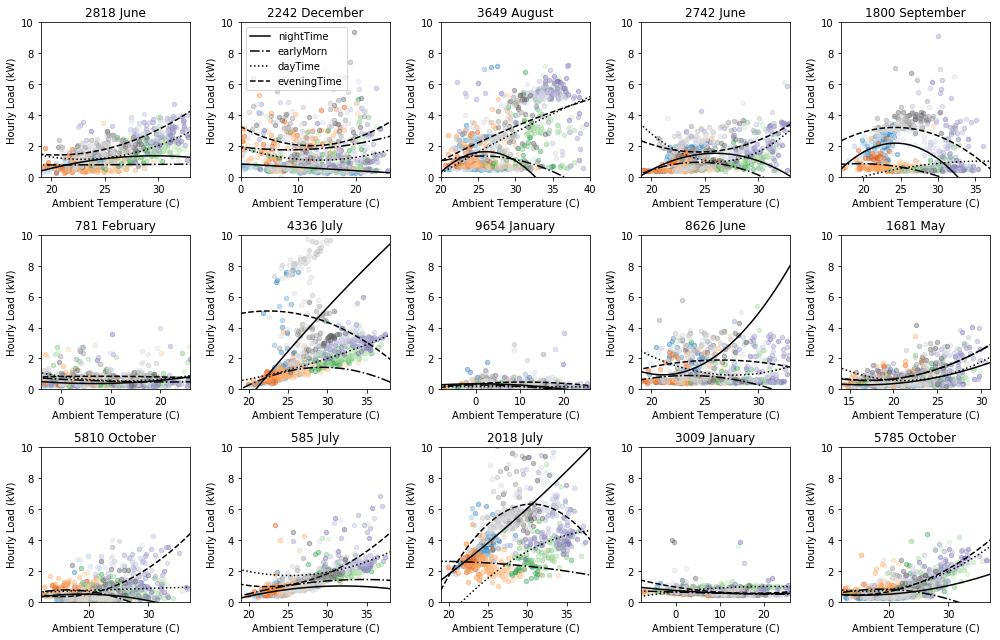

In [61]:
colorPal = sns.color_palette('hls',10)
fig = plt.figure(figsize=(14,9))
for j in range(15):
    uID = randIDs[j] # pick the user
    month = months[np.random.randint(len(months))]
    start = np.int(np.sum(daynum[0:months.index(month)])*24)
    end = np.int(np.sum(daynum[0:months.index(month)+1])*24)    
    nDays = int((end-start)/24)
    ax1 = fig.add_subplot(3,5,j+1)
    ax1.set_title('%d'%uID+' '+month)
    
    hourlyTempReshape = hourlyTemp[start:end].reshape(nDays,24)
    loadReshape = hourly_df.loc[uID][start:end]
    loadReshape = (loadReshape.values).reshape(nDays,24)
    
    for k in range(24):
        cl = scalarMap3.to_rgba((np.float(k+1)))
        cl = colors2.rgb2hex(cl)
        ax1.scatter(hourlyTempReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.4, color=cl)   
        
    ############ FIT POLYNOMIAL AT EACH TIME BLOCK ##########
    lines = []
    for k in range(4):
        coefs = poly.polyfit(hourlyTempReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 2)
        ffit = poly.polyval(xd, coefs)
        l, = plt.plot(xd, ffit, color='k', linestyle=lineStyles[k])
        lines.append(l)

    ax1.set_xlabel('Ambient Temperature (C)')
    ax1.set_ylabel('Hourly Load (kW)')
    ax1.set_xlim([np.floor(np.min(hourlyTempReshape)),np.ceil(np.max(hourlyTempReshape))])
    ax1.set_ylim([0,10])
    if j == 1:
        ax1.legend(lines,['nightTime', 'earlyMorn', 'dayTime', 'eveningTime'])
fig.tight_layout()


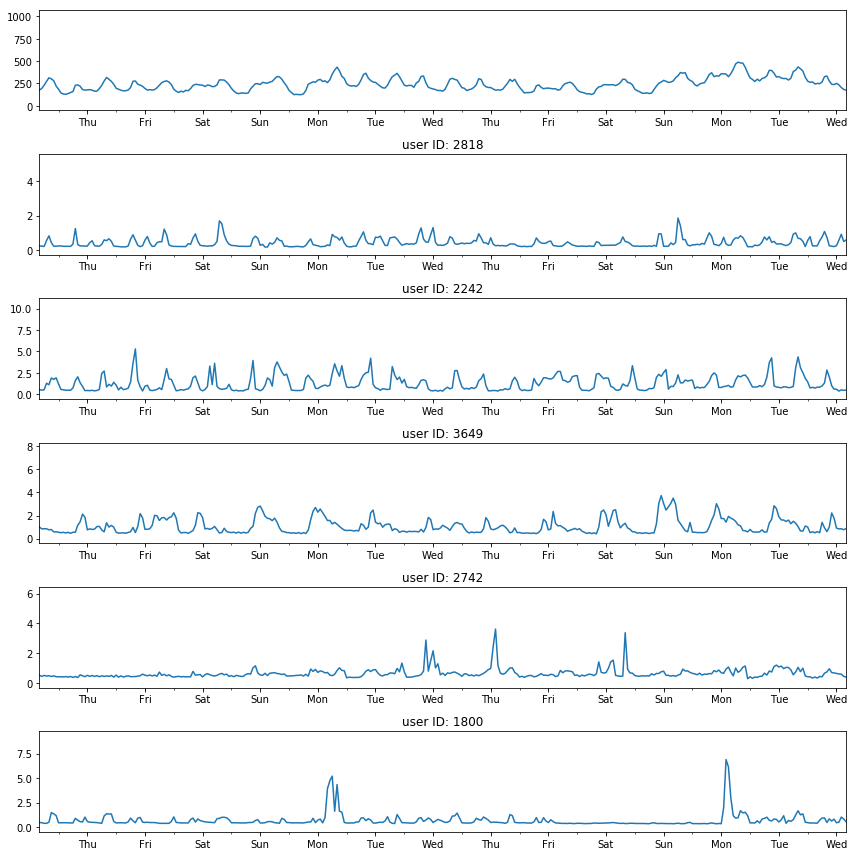

In [62]:
noPlots = 6
randIDs = randIDs[0:5]

fig = plt.figure(figsize=(12,12))
axs = []
window = [1000+0,1000+24*14]

dayLabels = ['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat','Sun']

indexVals = aggregateLoad.index
# find the first tick
for j,ind in enumerate(indexVals):
    if j >=window[0]:
        if ind.hour == 0:
            startTick =0+j
            break

for i in range(1,noPlots+1):
    axs.append(fig.add_subplot(6,1,i))
for i in range(noPlots):
    if i in [0]: # plot the aggregate load
        plotVals = aggregateLoad.values
        
        axs[i].plot(timePlot,plotVals)
    else:
        uID = randIDs[i-1]
        plotVals = hourly_df.loc[uID] #consumption_df[consumption_df['user_id']==uID].iloc[0,3:]
        axs[i].plot(timePlot,plotVals)
        
    axs[i].set_xlim(window)
    axs[i].set_xticks(np.arange(startTick,window[1],12), minor=True)
    axs[i].set_xticks(np.arange(startTick+12,window[1],24))
    tickLabs = []
    for ti in np.arange(startTick+12,window[1],24):
        tickLabs.append(dayLabels[indexVals[window[0]+ti].dayofweek])
    axs[i].set_xticklabels(tickLabs)
    if i>0:
        axs[i].set_title('user ID: %d'%uID)
fig.tight_layout()
# 2015 starts on thursday

In [63]:
users_to_highlight = [203,22,105]
idHighlight = [hourly_df.index[u] for u in users_to_highlight]

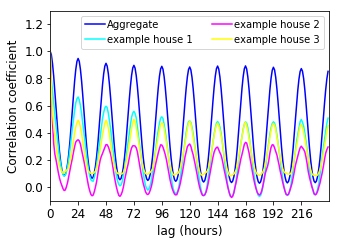

In [64]:
nD = 10
colors = ['b', 'cyan', 'magenta', 'yellow']
fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
proxys = []
for i in range(4):      
    # now lets look at autocorrelation of the load
    if i==0:
        loadNorm = aggregateLoad-aggregateLoad.mean()
    else:
        uID = idHighlight[i-1]
        loadNorm = hourly_df.loc[uID]-hourly_df.loc[uID].mean()
    lagNWeeks = np.zeros((24*nD))
    for j in range(len(lagNWeeks)):
        lagNWeeks[j] = loadNorm.autocorr(lag=j)
    
    l, = ax1.plot(np.arange(24*nD),lagNWeeks,color=colors[i])
    proxys.append(l)
ax1.set_xlabel('lag (hours)', fontsize=12)
ax1.set_ylabel('Correlation coefficient', fontsize=12)
ax1.set_xlim([0,24*nD])
ax1.set_xticks(np.arange(0,24*nD,24));
ax1.set_ylim([-0.1,1.3])

legLabs = []
legLabs.append('Aggregate')
for i in range(3):
    #legLabs.append('user ID: %d'%idHighlight[i])
    legLabs.append('example house %d'%(i+1))
plt.legend(proxys, legLabs,\
           ncol=2, fontsize=10, handletextpad=0.2)
ax1.tick_params(axis='both', labelsize=12)
# fig.savefig('../outputs/Autocorrelation.png', dpi=300, format='png',  bbox_inches='tight')

In [65]:
aggIndices = aggregateLoad.index
T_to_F = [1,2,3,4]
S_to_M = [5,6,0]

In [66]:
### what are the holidays 
# Thursday, January 1
# Monday, January 19
# Monday, February 16
# Monday, May 25
# Friday, July 3
# Monday, September 7
# Monday, October 12
# Wednesday, November 11
# Thursday, November 26
# Friday, December 25
a = aggIndices[0]
a.dayofyear

1

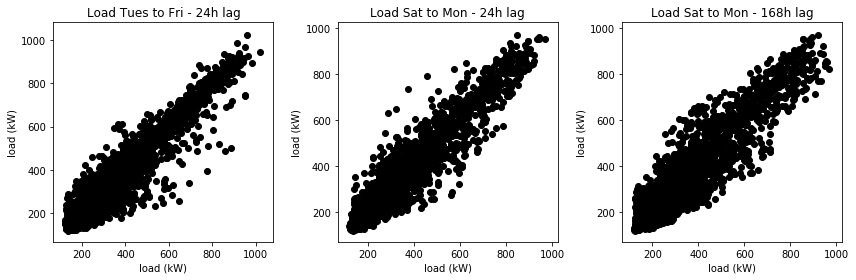

In [68]:
# scatter plot of load against load at previous time one day earlier
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# loop through the days
for day in range(int(endTrain/24)-1):
    startIndex = (day+1)*24
    dayOfWeek = aggIndices[startIndex].dayofweek
    if dayOfWeek in T_to_F:
        ax1.scatter(aggregateLoad[startIndex-24:startIndex], aggregateLoad[startIndex:startIndex+24], color='k')
    else:
        ax2.scatter(aggregateLoad[startIndex-24:startIndex], aggregateLoad[startIndex:startIndex+24], color='k')
        if day>6:
            ax3.scatter(aggregateLoad[startIndex-168:startIndex-144], \
                        aggregateLoad[startIndex:startIndex+24], color='k')
ax1.set_title('Load Tues to Fri - 24h lag')
ax2.set_title('Load Sat to Mon - 24h lag')
ax3.set_title('Load Sat to Mon - 168h lag')
ax1.set_xlabel('load (kW)'), ax1.set_ylabel('load (kW)')
ax2.set_xlabel('load (kW)'), ax2.set_ylabel('load (kW)')
ax3.set_xlabel('load (kW)'), ax3.set_ylabel('load (kW)')
fig.tight_layout()

In [69]:
randIDs

[2818, 2242, 3649, 2742, 1800]

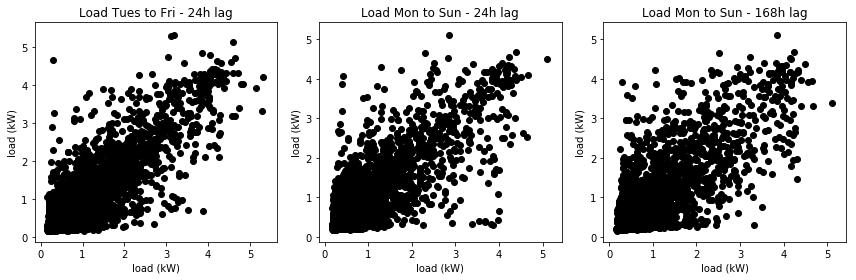

In [70]:
# scatter plot of load against load at previous time one day earlier
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# loop through the days

uID = randIDs[0]
testLoad = hourly_df.loc[uID]

for day in range(int(endTrain/24)-1):
    startIndex = (day+1)*24
    dayOfWeek = aggIndices[startIndex].dayofweek
    if dayOfWeek in T_to_F:
        ax1.scatter(testLoad[startIndex-24:startIndex], testLoad[startIndex:startIndex+24], color='k')
    else:
        ax2.scatter(testLoad[startIndex-24:startIndex], testLoad[startIndex:startIndex+24], color='k')
        if day>6:
            ax3.scatter(testLoad[startIndex-168:startIndex-144], testLoad[startIndex:startIndex+24], color='k')
ax1.set_title('Load Tues to Fri - 24h lag')
ax2.set_title('Load Mon to Sun - 24h lag')
ax3.set_title('Load Mon to Sun - 168h lag')
ax1.set_xlabel('load (kW)'), ax1.set_ylabel('load (kW)')
ax2.set_xlabel('load (kW)'), ax2.set_ylabel('load (kW)')
ax3.set_xlabel('load (kW)'), ax3.set_ylabel('load (kW)')
fig.tight_layout()

# Decide on the possible model features

start with an initial model:
$ \hat{P}_{t} = \sum_{i=1}^{2}[dayType_{t}^{(i)}(\beta_{0,i} + \beta_{1,i}P_{t-24} + \beta_{2,i}P_{t-168})] +
\sum_{i=1}^{4} [daySection_{t}^{(i)}(\beta_{3,i}+\beta_{4,i}T_t+\beta_{5,i}T_t^2)] $ <br>
* TF - Tuesday to Friday <br>
* SM - Saturday to Monday <br>
* We assume we know temperature (rather than forecast)
* there are 4 daySections (night, morning, afternoon, evening) which can have different tempertaure responses

In [71]:
dayClassifier = [[1,2,3,4],[5,6,0]]
# at the moment there are 2 24 lag features, 2 168 lag, 12 temperature
allFeatures = np.zeros((featureLength,18))
#allFeatures[:,0] = aggregateLoad[startTrain:endTrain-24]
yData = aggregateLoad[startTrain+168:endPred]
interestTemp = hourlyTemp[startTrain+168:endPred]
for j in range(len(yData)):
    hourTrain = yData.index[j].hour
    dayTrain = yData.index[j].dayofweek
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])
    allFeatures[j,0:2] = dummy# constants for tues-fri and sat-mon   
    
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])*aggregateLoad[(startTrain+168)+j-24] #24 hours before
    allFeatures[j,2:4] = dummy# linear terms for 24 hour lag for tues-fri and sat-mon

    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])*aggregateLoad[startTrain+j]
    allFeatures[j,4:6] = dummy# linear terms for 168 hour lag for tues-fri and sat-mon

    # in each daySection there is a constant, a linear temp term and a quadratic term
    dummy = np.zeros((len(timeLists)*3))
    for k in range(len(timeLists)):
        dummy[3*k:3*(k+1)] = (hourTrain in timeLists[k])
        dummy[3*k] = dummy[3*k]*interestTemp[j]
        dummy[3*k+1] = dummy[3*k+1]*(interestTemp[j]**2)
        dummy[3*k+2] = dummy[3*k+2]*1#(interestTemp[j]**3)*0
    allFeatures[j,6:] = dummy

In [72]:
aggregateLoad.head()

2015-01-01 00:00:00    268.628
2015-01-01 01:00:00    262.493
2015-01-01 02:00:00    250.312
2015-01-01 03:00:00    248.885
2015-01-01 04:00:00    262.073
dtype: float64

### Training Data

In [73]:
# remember we do not have features for the first week
allFeaturesTrain = allFeatures[startTrain:endTrain-168,:]

### Prediction data

In [74]:
# again, remeber no features for the first week
allFeaturesPredict = allFeatures[startPred-168:endPred-168,:]

In [75]:
np.shape(allFeaturesPredict)

(1464, 18)

In [76]:
# now make the models

In [79]:
# Model with quadratic temperature
clfQuadraticTemp = linear_model.LinearRegression(fit_intercept=True)
clfQuadraticTemp.fit(allFeaturesTrain, yData[startTrain:endTrain-168])
coefQuadraticTemp = clfQuadraticTemp.coef_

In [80]:
clfQuadraticTemp.intercept_

137.9238404027476

In [81]:
# get errors from training period
trainQuadraticTemp = clfQuadraticTemp.predict(allFeaturesTrain)

In [82]:
# temperature unaware model
clfTempUnaware = linear_model.LinearRegression(fit_intercept=True)
clfTempUnaware.fit(allFeaturesTrain[:,0:6], yData[startTrain:endTrain-168])
coefTempUnaware = clfTempUnaware.coef_

In [83]:
# Now look at the results on the validation period

In [84]:
# lets look at the predicted and actual load for the month of september
actual = aggregateLoad[startPred:endPred]
predictedQuadraticTemp = np.zeros((np.shape(actual)))
predictedTempUnaware = np.zeros((np.shape(actual)))
seasonalNaive1 = aggregateLoad[startPred-24:endPred-24].values
seasonalNaive2 = aggregateLoad[startPred-168:endPred-168].values

# predict using the cubic temp model
predictedQuadraticTemp = clfQuadraticTemp.predict(allFeaturesPredict)
# predict using the temp unaware model
predictedTempUnaware = clfTempUnaware.predict(allFeaturesPredict[:,0:6])

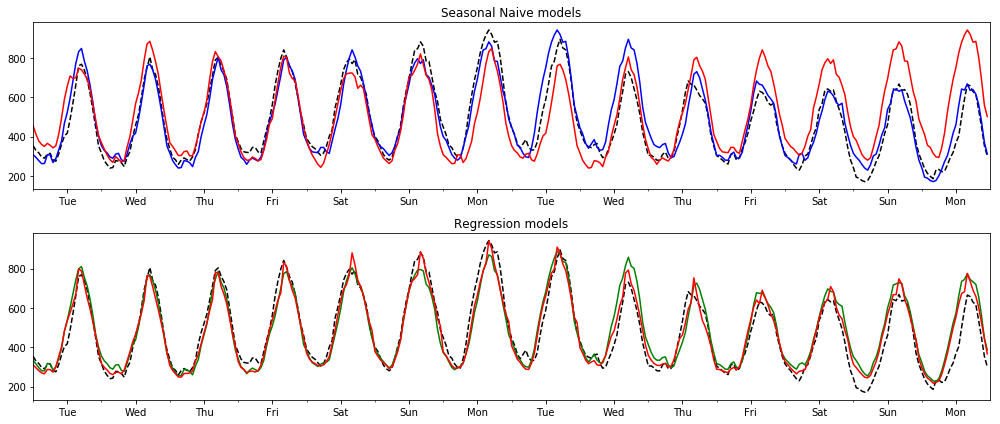

In [85]:
fig = plt.figure(figsize = (14,6))
axs = []
#nModels = 3
window = [0,336]
plotStart, plotEnd = startPred+window[0], startPred+window[1]
titles = ['Seasonal Naive models', 'Regression models']

for j in range(2):
    axs.append(fig.add_subplot(2,1,j+1))
    
indexVals = actual.index
# find the first tick
j = startPred+window[0]
for ind in indexVals:
    if j >= plotStart:
        if ind.hour == 0:
            startTick = 0+j
            break
    j+=1
    
for j in range(2):
    axs[j].plot(np.arange(plotStart,plotEnd), actual[window[0]:window[1]], color='k', linestyle='--')
    if j == 0:
        axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1[window[0]:window[1]], color='b', linestyle='-')
        axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive2[window[0]:window[1]], color='r', linestyle='-')
    elif j == 1:
        axs[j].plot(np.arange(plotStart,plotEnd), predictedTempUnaware[window[0]:window[1]], \
                    color='g', linestyle='-')
        axs[j].plot(np.arange(plotStart,plotEnd), predictedQuadraticTemp[window[0]:window[1]], \
                    color='r', linestyle='-')
    axs[j].set_xlim([plotStart,plotEnd])
    axs[j].set_title(titles[j])
    axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
    axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
    tickLabs = []
    for ti in np.arange(startTick+12,plotEnd,24):
        tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
    axs[j].set_xticklabels(tickLabs)
fig.tight_layout()

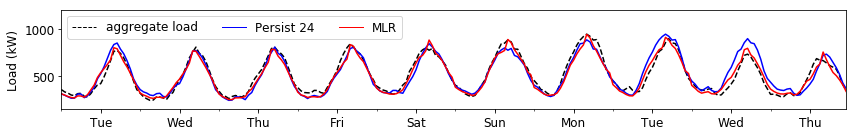

In [86]:
startPeriod = 96

fig = plt.figure(figsize = (12,2))
axs = []
window = [0,240]
plotStart, plotEnd = startPred+window[0], startPred+window[1]
titles = ['Aggregate Load', 'Individual Loads']
axs.append(fig.add_subplot(1,1,1))
    
indexVals = actual.index
# find the first tick
j = startPeriod+window[0]
for ind in indexVals:
    if j >= plotStart:
        if ind.hour == 0:
            startTick = 0+j
            break
    j+=1
j=0

axs[j].plot(np.arange(plotStart,plotEnd), actual[window[0]:window[1]], color='k', linestyle='--')

axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1[window[0]:window[1]], color='b', linestyle='-')

axs[j].plot(np.arange(plotStart,plotEnd), predictedQuadraticTemp[window[0]:window[1]], color='r', linestyle='-')

axs[j].set_xlim([plotStart,plotEnd-1])
axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
axs[j].set_ylim([150,1200])

tickLabs = []
for ti in np.arange(startTick+12,plotEnd,24):
    tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
axs[j].set_xticklabels(tickLabs);

axs[j].tick_params(axis='both', labelsize=12)
axs[j].set_ylabel('Load (kW)', fontsize=12);

lineLabels = ['Persist 24','MLR']
lines = []
line = mlines.Line2D([], [], color='k', label='aggregate load', linewidth=1, linestyle='--')
lines.append(line)
lineColors = ['b','r']
for j in range(2):
    line = mlines.Line2D([], [], color=lineColors[j], label=lineLabels[j], linewidth=1)
    lines.append(line)

axs[0].legend(handles=lines, ncol=3, fontsize=12, frameon=True)

fig.tight_layout()
# fig.savefig('../outputs/agg_result_10_days.png', dpi=300, format='png',  bbox_inches='tight')

In [87]:
# save the training data to create a NN
with open('../intermediateData/aggTrainingData.pickle', 'wb') as f:
    pickle.dump(allFeaturesTrain, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('../intermediateData/aggLoad.pickle', 'wb') as f:
    pickle.dump(aggregateLoad, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('../intermediateData/aggTestingData.pickle', 'wb') as f:
    pickle.dump(allFeaturesPredict, f, protocol=pickle.HIGHEST_PROTOCOL)

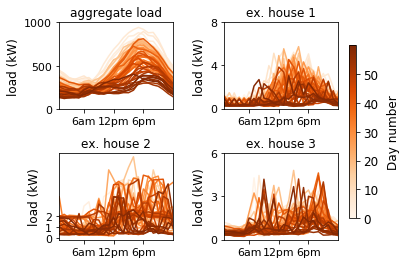

In [90]:
#create colormap which has EUI
minVal, maxVal = 0, 60.
cmOcc = plt.cm.get_cmap('Oranges')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

# Look at each day in the forecast period
fig = plt.figure(figsize = (5,4))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

counter = 0
for row in (actual.values).reshape(int(lenPrediction/24),24):
    cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
    cl = colors2.rgb2hex(cl)
    axs[0].plot(np.arange(1,25),row,color=cl)
    counter+=1

# look at the same for two random individuals
actualInd = hourly_df.loc[idHighlight[0]][startPred:endPred]
counter = 0
for row in (actualInd.values).reshape(int(lenPrediction/24),24):
    cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
    cl = colors2.rgb2hex(cl)
    axs[1].plot(np.arange(1,25),row,color=cl)
    counter+=1

actualInd = hourly_df.loc[idHighlight[1]][startPred:endPred]
counter = 0
for row in (actualInd.values).reshape(int(lenPrediction/24),24):
    cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
    cl = colors2.rgb2hex(cl)
    axs[2].plot(np.arange(1,25),row,color=cl)
    counter+=1
ax1.set_title('ex. house 2'), ax1.set_xlim([1,24]), ax1.set_ylabel('load (kW)'), ax1.set_xlabel('time');
ax1.tick_params(axis='both', labelsize=12)

actualInd = hourly_df.loc[idHighlight[2]][startPred:endPred]
counter = 0
for row in (actualInd.values).reshape(int(lenPrediction/24),24):
    cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
    cl = colors2.rgb2hex(cl)
    axs[3].plot(np.arange(1,25),row,color=cl)
    counter+=1

plotTitles = ['aggregate load', 'ex. house 1', 'ex. house 2', 'ex. house 3']
for i in range(4):
    axs[i].set_title(plotTitles[i])
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('load (kW)', fontsize=12)
    axs[i].set_xticks(np.array([6,12,18]))
    axs[i].set_xticklabels(['6am','12pm','6pm'])
    axs[i].tick_params(axis='both', labelsize=11)
axs[0].set_yticks([0,500,1000])    
axs[1].set_yticks([0,4,8])
axs[2].set_yticks([0,1,2])
axs[3].set_yticks([0,3,6])
plt.subplots_adjust(wspace=0.45, hspace=0.5)

cbar_ax = plt.axes([0.93, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,60,10), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=12)
cbar.set_label('Day number', labelpad=9, rotation=90, fontsize=12)
# fig.savefig('../outputs/daily_load_evolution_aggregate_vs_individual.png',\
# dpi=300, format='png',  bbox_inches='tight')

In [91]:
# calculate MAPE's for the forecast
APEs = np.zeros((lenPrediction,4))
APEs[:,0] = np.abs(seasonalNaive1-actual)/np.abs(actual)
APEs[:,1] = np.abs(seasonalNaive2-actual)/np.abs(actual)
APEs[:,2] = np.abs(predictedTempUnaware-actual)/np.abs(actual)
APEs[:,3] = np.abs(predictedQuadraticTemp-actual)/np.abs(actual)

In [92]:
MAPEs = np.mean(APEs, axis=0)

[0.12010184 0.22021079 0.12519621 0.1009812 ]


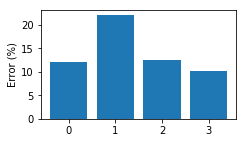

In [94]:
fig = plt.figure(figsize=(3.5,2))
plt.bar([0,1,2,3],MAPEs*100)
plt.ylabel('Error (%)')
print(MAPEs)

In [95]:
startTrain, endTrain, len(trainQuadraticTemp), 168+5664, len(aggregateLoad[startTrain+144:endTrain-24])

(0, 5832, 5664, 5832, 5664)

In [96]:
APEsTrain = np.zeros((len(trainQuadraticTemp),2))
APEsTrain[:,0] = np.abs(trainQuadraticTemp-yData[0:len(trainQuadraticTemp)])/np.abs(yData[0:len(trainQuadraticTemp)])
APEsTrain[:,1] = np.abs(aggregateLoad[startTrain+144:endTrain-24].values-yData[0:len(trainQuadraticTemp)])/np.abs(yData[0:len(trainQuadraticTemp)])

In [97]:
np.mean(APEsTrain, axis=0)

array([0.09335828, 0.12668869])

### Now look at the forecasts for single users

In [98]:
np.shape(allFeatures)

(7128, 18)

In [99]:
featureLength

7128

In [100]:
endPred-(startTrain+168)

7128

In [101]:
nUsers = len(hourly_df)
allFeaturesIndividual = np.zeros((featureLength,12+6*nUsers))

# temperature based features (interact with hour)
allFeaturesIndividual[:,0:12] = allFeatures[:,6:]

for nU in range(nUsers):
    allFeaturesIndividual[:,12+(6*nU)] = 1.
    allFeaturesIndividual[:,12+(6*nU+1)] = 1.
    allFeaturesIndividual[:,12+(6*nU+2)] = hourly_df.iloc[nU][startTrain+144:endPred-24].values
    allFeaturesIndividual[:,12+(6*nU+3)] = hourly_df.iloc[nU][startTrain+144:endPred-24].values
    allFeaturesIndividual[:,12+(6*nU+4)] = hourly_df.iloc[nU][startTrain:endPred-168].values
    allFeaturesIndividual[:,12+(6*nU+5)] = hourly_df.iloc[nU][startTrain:endPred-168].values

# day interact with 1 week and 1 week before features
for j in range(featureLength):
    dayTrain = yData.index[j].dayofweek
    
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])
        
    for nU in range(nUsers):
        # constants
        allFeaturesIndividual[j,12+(6*nU)] = dummy[0]*allFeaturesIndividual[j,12+(6*nU)]
        allFeaturesIndividual[j,12+(6*nU+1)] = dummy[1]*allFeaturesIndividual[j,12+(6*nU+1)]
        # 24 hr lag
        allFeaturesIndividual[j,12+(6*nU+2)] = dummy[0]*allFeaturesIndividual[j,12+(6*nU+2)]
        allFeaturesIndividual[j,12+(6*nU+3)] = dummy[1]*allFeaturesIndividual[j,12+(6*nU+3)]
        # 168 hr lag
        allFeaturesIndividual[j,12+(6*nU+4)] = dummy[0]*allFeaturesIndividual[j,12+(6*nU+4)]
        allFeaturesIndividual[j,12+(6*nU+5)] = dummy[1]*allFeaturesIndividual[j,12+(6*nU+5)]

### Training data

In [102]:
# remember we do not have features for the first week
allFeaturesIndividualTrain = allFeaturesIndividual[startTrain:endTrain-168,:]

### Prediction data

In [103]:
# again, remember we do not have features for the first week!!
allFeaturesIndividualPredict = allFeaturesIndividual[startPred-168:endPred-168,:]

In [104]:
predQuadraticTempIndividual = np.zeros((nUsers, len(actual)))
predTempUnawareIndividual = np.zeros((nUsers, len(actual)))
seasonalNaive1Individual = np.zeros((nUsers, len(actual)))
seasonalNaive2Individual = np.zeros((nUsers, len(actual)))

for nU in range(nUsers):
    seasonalNaive1Individual[nU,:] = hourly_df.iloc[nU,startPred-24:endPred-24].values
    seasonalNaive2Individual[nU,:] = hourly_df.iloc[nU,startPred-168:endPred-168].values

for nU in range(nUsers):
    columns = []
    for j in range(12):
        columns.append(j)
    for j in range(12+(nU*6),12+(nU*6+6)):
        columns.append(j)
    
    clfQuadraticTempIndividual = linear_model.LinearRegression(fit_intercept=True)
    clfQuadraticTempIndividual.fit(allFeaturesIndividualTrain[:,columns], \
                                   hourly_df.iloc[nU,startTrain+168:endTrain].values)
    # predict using the cubic temp model
    predQuadraticTempIndividual[nU,:] = clfQuadraticTempIndividual.predict(allFeaturesIndividualPredict[:,columns])
    
    # Model seasonal only temp unaware
    columns = columns[12:]
    clfTempUnawareIndividual = linear_model.LinearRegression(fit_intercept=True)
    clfTempUnawareIndividual.fit(allFeaturesIndividualTrain[:,columns], \
                                 hourly_df.iloc[nU,startTrain+168:endTrain].values)
    # predict using the temp unaware model
    predTempUnawareIndividual[nU,:] = clfTempUnawareIndividual.predict(allFeaturesIndividualPredict[:,columns])

In [105]:
actualIndividual = hourly_df.iloc[:,startPred:endPred].values

In [106]:
############## Get the errors for the training period ##################
trainQuadraticTempIndividual = np.zeros((nUsers, len(allFeaturesIndividualTrain)))
trainSeasonalNaive1Individual = np.zeros((nUsers, len(allFeaturesIndividualTrain)))
trainActual = np.zeros((nUsers, len(allFeaturesIndividualTrain)))

for nU in range(nUsers):
    trainSeasonalNaive1Individual[nU,:] = hourly_df.iloc[nU,startTrain+144:endTrain-24].values
    trainActual[nU,:] = hourly_df.iloc[nU,startTrain+168:endTrain].values 

for nU in range(nUsers):
    columns = []
    for j in range(12):
        columns.append(j)
    for j in range(12+(nU*6),12+(nU*6+6)):
        columns.append(j)
    
    clfQuadraticTempIndividual = linear_model.LinearRegression(fit_intercept=True)
    clfQuadraticTempIndividual.fit(allFeaturesIndividualTrain[:,columns], \
                                   hourly_df.iloc[nU,startTrain+168:endTrain].values)
    # predict using the cubic temp model
    trainQuadraticTempIndividual[nU,:] = clfQuadraticTempIndividual.predict(allFeaturesIndividualTrain[:,columns])

### Predict the individual loads using clustering

In [107]:
def mydist(p1, p2, distance_matrix):
    return emd(p1,p2,distance_matrix)

def clusterIndividuals(clusterLoadsList):
    MAX_D = 2.
    distance_matrix = np.zeros((24,24))
    for i in range(24):
        distance_matrix[i,i:] = np.arange(0,24-i)
        if i > 0:
            a = np.arange(1,i+1)
            distance_matrix[i,0:i] = a[::-1]
            
    # output
    cIdxList = []
    
    for clusterLoads in clusterLoadsList:
        closeness_matrix = np.zeros((len(clusterLoads),len(clusterLoads)))
        for i in range(len(clusterLoads)):
            for j in range(i,len(clusterLoads)):
                if i==j:
                    closeness_matrix[i,j] = 0
                else:
                    closeness_matrix[i,j] = mydist(clusterLoads[i], clusterLoads[j], distance_matrix)
            for j in range(i):
                closeness_matrix[i,j] = closeness_matrix[j,i]
        # create the necessary distances format for hierarchical
        dists = squareform(closeness_matrix)
        Z = linkage(dists, "complete")
        # This is the cutoff for forming the clusters
        cIdx = fcluster(Z, MAX_D, criterion='distance')
        cIdxList.append(cIdx)
    return cIdxList

In [110]:
daysTrain = int(endTrain-startTrain)/24
# now use the function to create some clusters
clusterLoadsList, dayLoadsList = [], []
for userOfInterest in range(len(hourly_df)):
    dayLoads = np.ascontiguousarray( hourly_df.iloc[userOfInterest,startTrain:endTrain].\
                                    values.reshape(int(daysTrain),24) )
    clusterLoads = np.zeros(np.shape(dayLoads))
    for d, load in enumerate(dayLoads):
        if(sum(load))>0:
            clusterLoads[d,:] = load/sum(load)
    clusterLoadsList.append(clusterLoads)
    dayLoadsList.append(dayLoads)
    
distance_matrix = np.zeros((24,24))
for i in range(24):
    distance_matrix[i,i:] = np.arange(0,24-i)
    if i > 0:
        a = np.arange(1,i+1)
        distance_matrix[i,0:i] = a[::-1]

In [111]:
import multiprocessing
multiprocessing.cpu_count()

4

In [113]:
noCores = 2
startTime = time.time()
p = Pool(noCores)
cIdxList = p.map( clusterIndividuals, (clusterLoadsList[i::noCores] for i in range(noCores)) )
print('elapsed time: %.f'%(time.time()-startTime))

elapsed time: 1666


In [114]:
# recombine the cIdx lists
newCIdxList = []
for nU in range(nUsers):
    cycleElement, listElement = divmod(nU,noCores)
    newCIdxList.append(cIdxList[listElement][cycleElement])
cIdxList = newCIdxList
# renumber all clusters from 0 --> K-1 rather than 1 --> K
for nU in range(nUsers):
    cIdxList[nU] = cIdxList[nU]-1

In [115]:
daysTrain

243.0

In [118]:
# pieces needed for the cluster forecasting
daysPredict = np.arange(int(startPred/24),int(endPred/24))

######## CALCULATE TRAINING ERRORS AFTER 1st WEEK ###########
daysTrainingError = np.arange(7,endTrain/24)

# Temperature cubic coefficients all users 
dailyTemp = np.mean(hourlyTemp.reshape(365,24), axis=1)
# get weekend and weekday daily temperatures
weekendTemp, weekdayTemp = [], []
# 2015 starts on thursday
dayOfWeek = 3
for j in range(int(daysTrain)):
    if dayOfWeek in [0,1,2,3,4]:
        weekdayTemp.append(dailyTemp[j])
    else:
        weekendTemp.append(dailyTemp[j])
    dayOfWeek+=1
    dayOfWeek = dayOfWeek%7
weekdayTemp = np.asarray(weekdayTemp)
weekendTemp = np.asarray(weekendTemp)

# user dependent properties
coefsWD = np.zeros((nUsers,4))
coefsWE = np.zeros((nUsers,4))
for nU in range(nUsers):
    dailyConsumption = np.sum(dayLoadsList[nU], axis=1)
    # get weekend and weekday daily consumptions
    weekendConsumption = []
    weekdayConsumption = []
    # 2015 starts on thursday
    dayOfWeek = 3
    for j in range(int(daysTrain)):
        if dayOfWeek in [0,1,2,3,4]:
            weekdayConsumption.append(dailyConsumption[j])
        else:
            weekendConsumption.append(dailyConsumption[j])
        dayOfWeek+=1
        dayOfWeek = dayOfWeek%7    
    weekdayConsumption = np.asarray(weekdayConsumption)    
    weekendConsumption = np.asarray(weekendConsumption)
    
    coefsWD[nU,:] = poly.polyfit(weekdayTemp[weekdayConsumption<np.percentile(dailyConsumption, 99)], \
                     weekdayConsumption[weekdayConsumption<np.percentile(dailyConsumption, 99)], 3)
    coefsWE[nU,:] = poly.polyfit(weekendTemp[weekendConsumption<np.percentile(dailyConsumption, 99)], \
                     weekendConsumption[weekendConsumption<np.percentile(dailyConsumption, 99)], 3)


### the next three cells generate the errors for the training period

In [119]:
testLen = (endTrain-168)

In [120]:
clusterTrainingLoadsTemp = np.zeros((nUsers, testLen))
clusterTrainingLoads24Lag = np.zeros((nUsers, testLen))

In [123]:
for nU, cIdx in enumerate(cIdxList):
    K = len(set(cIdx))
    
    # get the centroids
    clusterLoads = clusterLoadsList[nU]
    centroids = np.zeros((K,24))
    for j,clusNo in enumerate(np.arange(0,K)):
        centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)
    # transition matrix
    pTrans = np.zeros((K,K,2))
    M_F = [0,1,2,3,4]
    for j in range(len(cIdx)):
        dayStart = j*24
        if j>0:
            # get the day of the week
            dayLabel = hourly_df.columns[dayStart].dayofweek
            if dayLabel in M_F:
                if dayLabel in M_F[1:]:
                    pTrans[cIdx[j-1],cIdx[j],0]+=1
                else:
                    pTrans[cIdx[j-3],cIdx[j],0]+=1
            else:
                if dayLabel==5:
                    pTrans[cIdx[j-6],cIdx[j],1]+=1
                else:
                    pTrans[cIdx[j-1],cIdx[j],1]+=1
                    
    # normalise transition matrix
    for j in range(K):
        if sum(pTrans[j,:,0])>0:
            pTrans[j,:,0]=pTrans[j,:,0]/sum(pTrans[j,:,0])
        if sum(pTrans[j,:,1])>0:
            pTrans[j,:,1]=pTrans[j,:,1]/sum(pTrans[j,:,1])
    
    # now generate forecast
    for dayNo, day in enumerate(daysTrainingError):
        day = int(day)
        dayOfWeekPredict = hourly_df.columns[day*24].dayofweek
        # predict the next cluster
        if dayOfWeekPredict in M_F:
            if dayOfWeekPredict==0:
                previousDayCluster = cIdx[day-3]
            else:
                previousDayCluster = cIdx[day-1]
            options = pTrans[previousDayCluster,:,0]
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))]            
            # get temp relationship
            releventCoeffs = coefsWD[nU,:]
        else:
            if dayOfWeekPredict==5:
                previousDayCluster = cIdx[day-6]
            else:
                previousDayCluster = cIdx[day-1]
            options = pTrans[previousDayCluster,:,1]
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))]
            # get relevent temp coeffs
            releventCoeffs = coefsWE[nU,:]

        predictedTemp = dailyTemp[day]
        dayMagnitude1 = poly.polyval(predictedTemp, releventCoeffs)
        dayMagnitude2 = sum(hourly_df.iloc[nU,(day-1)*24:(day)*24])
        # use dayNo for the index below
        clusterTrainingLoadsTemp[nU, dayNo*24:(dayNo+1)*24] = centroids[newDayCluster]*dayMagnitude1
        clusterTrainingLoads24Lag[nU, dayNo*24:(dayNo+1)*24] = centroids[newDayCluster]*dayMagnitude2

## forecasting with updated clusters

* do the clustering for trainingDays
* create a trasnition matrix with decay
* predict next day
* classify the new day in clusters
* update the transition matrix
* Repeat steps 2-6 until all days are predicted

In [124]:
timeLabels = hourly_df.columns

In [125]:
def clusterPredictLoads(userNU, cIdxList, daysPredict, clusterLoadsList, timeLabels, \
                        userCoefWDList, userCoefWEList, userLoadList, magOpt):
    loadPredictionList = []
    userRun = []
    for counter, cIdx in enumerate(cIdxList):
        clusterLoads = clusterLoadsList[counter]
        userCoefWD = userCoefWDList[counter]
        userCoefWE = userCoefWEList[counter]
        userLoad = userLoadList[counter]
        nU = userNU[counter]
        
        K = len(set(cIdx))

        # INITIALIZE the centroids
        centroids = np.zeros((K,24))
        for j,clusNo in enumerate(np.arange(0,K)):
            centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)

        # initialize output array
        loadPrediction = np.zeros((len(daysPredict)*24))

        #### FORECAST LOAD ####
        for day in range(len(daysPredict)):
            # create the tranistion matrix
            pTrans = np.zeros((K,K,2))
            M_F = [0,1,2,3,4]
            for j in range(len(cIdx)):
                dayIndex = len(cIdx)-j-1 # work backwards
                dayStart = dayIndex*24
                if dayIndex>0:
                    # get the day of the week
                    dayLabel = timeLabels[dayStart].dayofweek
                    if dayLabel in M_F:
                        if dayLabel in M_F[1:]: # not a monday
                            pTrans[cIdx[dayIndex-1],cIdx[dayIndex],0]+=1#*np.exp(-j/np.float(transitionDecay))
                        else:
                            pTrans[cIdx[dayIndex-3],cIdx[dayIndex],0]+=1#*np.exp(-j/np.float(transitionDecay))
                    else:
                        if dayLabel==5:
                            pTrans[cIdx[dayIndex-6],cIdx[dayIndex],1]+=1#*np.exp(-j/np.float(transitionDecay))
                        else:
                            pTrans[cIdx[dayIndex-1],cIdx[dayIndex],1]+=1#*np.exp(-j/np.float(transitionDecay))

            # create normalised transition matrix
            for j in range(K):
                if sum(pTrans[j,:,0])>0:
                    pTrans[j,:,0]=pTrans[j,:,0]/sum(pTrans[j,:,0])
                if sum(pTrans[j,:,1])>0:
                    pTrans[j,:,1]=pTrans[j,:,1]/sum(pTrans[j,:,1])

            # forecast the next day
            dayOfWeekPredict = timeLabels[startPred+day*24].dayofweek
            # predict the next cluster
            if dayOfWeekPredict in M_F:
                if dayOfWeekPredict==0:
                    previousDayCluster = cIdx[daysPredict[day]-3]
                else:
                    previousDayCluster = cIdx[daysPredict[day]-1]
                tempCoefs = userCoefWD # get the temperature response
            else:
                if dayOfWeekPredict==5:
                    previousDayCluster = cIdx[daysPredict[day]-6]
                else:
                    previousDayCluster = cIdx[daysPredict[day]-1]
                tempCoefs = userCoefWE # get the temperature response

            options = pTrans[previousDayCluster,:,0]
            
            ########### PICK LIKLIEST CLUSTER ####################
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))] 
            
            ########### RANDOM FROM PROBABILITY DISTRIBUTION #########
            # optionsInd = [i for i,x in enumerate(options) if x>0]
            # optionsSum = np.zeros((len(optionsInd)+1))
            # optionsSum[1:] = np.cumsum(options[optionsInd])  
            # chosen, binEdges = np.histogram(np.random.rand(), bins=optionsSum, density=False)
            # if not np.any(chosen):
            #      newDayCluster = previousDayCluster
            # else:
            #     newDayCluster = [optionsInd[i] for i in range(len(optionsInd)) if chosen[i]==1][0]            
            
            # now use the temperature function to get the magnitiude
            predictedTemp = dailyTemp[daysPredict[day]]
            if magOpt == 'Temperature':
                dayMagnitude = poly.polyval(predictedTemp, tempCoefs)
            elif magOpt == 'previousDay':
                dayMagnitude = sum(userLoad[startPred+(day-1)*24:startPred+(day)*24])
            else:
                print('Error')
                dayMagnitude = []
            loadPrediction[day*24:(day+1)*24] = centroids[newDayCluster]*dayMagnitude

            # classify the actual Load
            actualLoad = userLoad[startPred+day*24:startPred+(day+1)*24]
            normLoad = actualLoad/sum(actualLoad)
            distancesToCentroids = np.zeros((K))
            for j,centroid in enumerate(centroids):
                distancesToCentroids[j] = mydist(p1=normLoad, p2=centroid, distance_matrix=distance_matrix)
            actualLoad = np.zeros((1,24))
            actualLoad[0,:] = normLoad

            # now update cIdx and the centroids
            cIdx = np.append(cIdx, np.argmin(distancesToCentroids), axis=None)
            clusterLoads = np.append(clusterLoads, actualLoad, axis=0)
            centroids = np.zeros((K,24))
            for j,clusNo in enumerate(np.arange(0,K)):
                centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)
            
        userRun.append(nU)
        loadPredictionList.append(loadPrediction)
        
    return userRun, loadPredictionList

In [126]:
userNumber = np.arange(0,len(hourly_df))

In [127]:
allLoadsList = []
for nU in userNumber:
    allLoadsList.append(hourly_df.iloc[nU,:].values)

In [128]:
def multi_run_wrapper(args):
    return clusterPredictLoads(*args)

* magOptions are 'Temperature' OR 'previousDay'

In [130]:
magOption = 'Temperature'
startTime = time.time()
noCores = 2
p = Pool(noCores)
x = p.map( multi_run_wrapper, ((userNumber[i::noCores], cIdxList[i::noCores], daysPredict, \
                                clusterLoadsList[i::noCores], timeLabels, coefsWD[i::noCores], \
                                coefsWE[i::noCores], allLoadsList[i::noCores], magOption) \
                               for i in range(noCores)) )
print('elapsed time: %.2f'%(time.time()-startTime))

elapsed time: 78.01


In [131]:
clusterPredictedLoadsTemp = np.zeros((nUsers, (endPred-startPred)))
for x_ in x:
    for j,num in enumerate(x_[0]):
        clusterPredictedLoadsTemp[num,:] = x_[1][j]

In [132]:
transitionDecay = 0 # unused
magOption = 'previousDay'
startTime = time.time()
p = Pool(noCores)
x = p.map( multi_run_wrapper, ((userNumber[i::noCores], cIdxList[i::noCores], daysPredict, \
                                clusterLoadsList[i::noCores], timeLabels, coefsWD[i::noCores], \
                                coefsWE[i::noCores], allLoadsList[i::noCores], magOption) \
                               for i in range(noCores)) )
print('elapsed time: %.2f'%(time.time()-startTime))

elapsed time: 77.94


In [133]:
clusterPredictedLoads24Lag = np.zeros(np.shape(clusterPredictedLoadsTemp))
for x_ in x:
    for j,num in enumerate(x_[0]):
        clusterPredictedLoads24Lag[num,:] = x_[1][j]

## create a validation period and look at the errors

In [134]:
startVal,endVal = 0,732
startTes,endTes = 732,1464

In [135]:
valMAPEs = np.zeros((nUsers,4))
for j in range(nUsers):
    valMAPEs[j,0] = np.mean( np.abs(actualIndividual[j,startVal:endVal]-seasonalNaive1Individual[j,startVal:endVal])\
                         /np.abs(actualIndividual[j,startVal:endVal]) )
    valMAPEs[j,1] = np.mean( np.abs(actualIndividual[j,startVal:endVal]-predQuadraticTempIndividual[j,startVal:endVal])\
                         /np.abs(actualIndividual[j,startVal:endVal]) )
    valMAPEs[j,2] = np.mean( np.abs(actualIndividual[j,startVal:endVal]-clusterPredictedLoadsTemp[j,startVal:endVal])\
                         /np.abs(actualIndividual[j,startVal:endVal]) )
    valMAPEs[j,3] = np.mean( np.abs(actualIndividual[j,startVal:endVal]-clusterPredictedLoads24Lag[j,startVal:endVal])\
                         /np.abs(actualIndividual[j,startVal:endVal]) )

/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Now get the training period errors

In [136]:
# testing period errors
trainMAPEs = np.zeros((nUsers,4))
for j in range(nUsers):
    trainMAPEs[j,0] = np.mean( np.abs(trainActual[j,:]-trainSeasonalNaive1Individual[j,:])\
                         /np.abs(trainActual[j,:]) )
    trainMAPEs[j,1] = np.mean( np.abs(trainActual[j,:]-trainQuadraticTempIndividual[j,:])\
                         /np.abs(trainActual[j,:]) )
    trainMAPEs[j,2] = np.mean( np.abs(trainActual[j,:]-clusterTrainingLoadsTemp[j,:])\
                         /np.abs(trainActual[j,:]) )
    trainMAPEs[j,3] = np.mean( np.abs(trainActual[j,:]-clusterTrainingLoads24Lag[j,:])\
                         /np.abs(trainActual[j,:]) )

/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [137]:
np.median(trainMAPEs,axis=0)

array([0.57817205, 0.55445293, 0.56496817, 0.53266463])

In [138]:
modelBins = np.arange(0,4.1)
hist, bin_Edges = np.histogram(np.argmin(trainMAPEs, axis=1), modelBins)
hist

array([ 31,  71,  43, 110])

## select the best model from each based on the validation period

In [139]:
# create a mixedModel with the different forecasts for the test period
mixedModel = np.zeros((len(seasonalNaive1Individual),endTes-startTes))
for nU in userNumber:
    modelNo = np.argmin(valMAPEs[nU,:])
    if modelNo==0:
        mixedModel[nU,:]=seasonalNaive1Individual[nU,startTes:endTes]
    elif modelNo==1:
        mixedModel[nU,:]=predQuadraticTempIndividual[nU,startTes:endTes]
    elif modelNo==2:
        mixedModel[nU,:]=clusterPredictedLoadsTemp[nU,startTes:endTes]
    elif modelNo==3:
        mixedModel[nU,:]=clusterPredictedLoads24Lag[nU,startTes:endTes]
    else:
        print('oops')

In [140]:
endTes=732+168*3

In [141]:
MAPEs = np.zeros((nUsers,5))
for j in range(nUsers):
    MAPEs[j,0] = np.mean( np.abs(actualIndividual[j,startTes:endTes]-seasonalNaive1Individual[j,startTes:endTes])\
                         /np.abs(actualIndividual[j,startTes:endTes]) )
    MAPEs[j,1] = np.mean( np.abs(actualIndividual[j,startTes:endTes]-predQuadraticTempIndividual[j,startTes:endTes])\
                         /np.abs(actualIndividual[j,startTes:endTes]) )
    MAPEs[j,2] = np.mean( np.abs(actualIndividual[j,startTes:endTes]-clusterPredictedLoadsTemp[j,startTes:endTes])\
                         /np.abs(actualIndividual[j,startTes:endTes]) )
    MAPEs[j,3] = np.mean( np.abs(actualIndividual[j,startTes:endTes]-clusterPredictedLoads24Lag[j,startTes:endTes])\
                         /np.abs(actualIndividual[j,startTes:endTes]) )
    MAPEs[j,4] = np.mean( np.abs(actualIndividual[j,startTes:endTes]-mixedModel[j,0:168*3])\
                         /np.abs(actualIndividual[j,startTes:endTes]) )

In [142]:
print(np.median(MAPEs,axis=0))

MAPEsIncBest = np.copy(MAPEs)

[0.55342398 0.5593162  0.53357834 0.53346055 0.50814669]


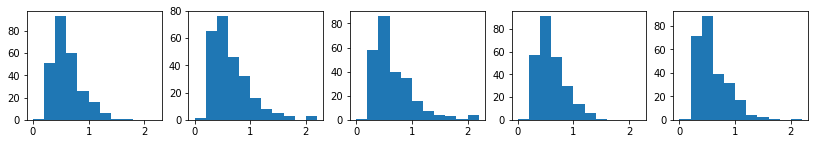

In [143]:
# plot the distributions of MAPE

fig = plt.figure(figsize = (14,2))
for j in range(5):
    ax1 = fig.add_subplot(1,5,j+1)
    binsAPE = np.arange(0,2.3,0.2)
    binsAPE[-1] = 20
    histAPE, edgesAPE = np.histogram(MAPEs[:,j], bins=binsAPE, density=False)
    edgesAPE[-1] = 2.2
    widths = edgesAPE[1:]-edgesAPE[0:-1]
    ax1.bar(edgesAPE[0:-1]+widths/2,histAPE,width=widths)

In [144]:
#MAPEs[:,4]=MAPEs[:,4]-0.01 #to see which users best models
MAPEs = MAPEs[:,0:4]

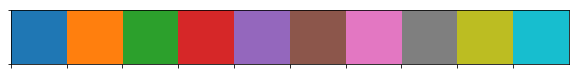

In [145]:
A = sns.color_palette()
sns.palplot(A)

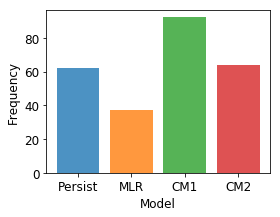

In [146]:
# plot the bars of how many households have each model as the best
modelBins = np.arange(0,4.1)
hist, bin_Edges = np.histogram(np.argmin(MAPEs, axis=1), modelBins)

fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
ax1.bar(np.arange(0,4), hist, color=A[0:4], alpha=0.8)
ax1.set_xticks(np.arange(0,4))
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xticklabels(['Persist','MLR','CM1','CM2']);
# fig.savefig('../outputs/noBestModel.png', dpi=300, format='png',  bbox_inches='tight')

In [147]:
hist

array([62, 37, 92, 64])

Text(0.5, 0, '$\\Delta$ MAPE (%)')

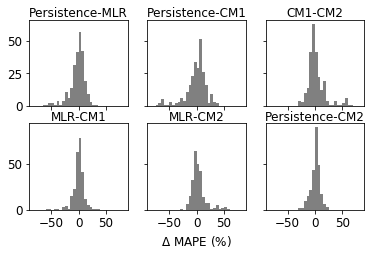

In [148]:
# plot distributions of where which model is better
names = ['Persistence','MLR','CM1','CM2']
fig, axs = plt.subplots(2,3, figsize=(6,3.5), facecolor='w', edgecolor='k', sharex='col', sharey='row')
axs = axs.ravel()
differenceBins = np.arange(-100.,101.,5)
modelDiffs = [[0,1],[0,2],[2,3],[1,2],[1,3],[0,3]]
for j in range(6):
    differences = 100*MAPEs[:,modelDiffs[j][0]] - 100*MAPEs[:,modelDiffs[j][1]]
    hist, bin_Edges = np.histogram(differences, differenceBins, density=False)
    widths = bin_Edges[1:]-bin_Edges[0:-1]
    axs[j].bar(bin_Edges[0:-1]+widths/2,hist,width=widths,color='grey',alpha=1.)
    axs[j].set_xlim([-90,90])
    strText = names[modelDiffs[j][0]]+'-'+names[modelDiffs[j][1]]
    axs[j].text(0.5,1.07,strText, horizontalalignment='center', \
                verticalalignment='center', transform=axs[j].transAxes,fontsize=12)
    axs[j].tick_params(axis='both', labelsize=12)
axs[4].set_xlabel(r'$\Delta$ MAPE (%)', fontsize=12)
# fig.savefig('../outputs/modelDifferences.png', dpi=300, format='png',  bbox_inches='tight')

In [149]:
print(MAPEs[227,:])
print(MAPEs[26,:])

[0.36927865 0.39599624 0.33940751 0.36120447]
[0.36811916 0.29993617 0.28800138 0.31807441]


In [150]:
# boxplots of the statistical properties of consumers who have a particular better forecast
indMinError = np.argmin(MAPEs, axis=1)

In [151]:
MAPEsIncMin = np.zeros((len(MAPEs),5))
MAPEsIncMin[:,0:4] = MAPEs
for j in range(len(MAPEs)):
    MAPEsIncMin[j,4] = MAPEs[j,indMinError[j]]

In [152]:
nUsers

255

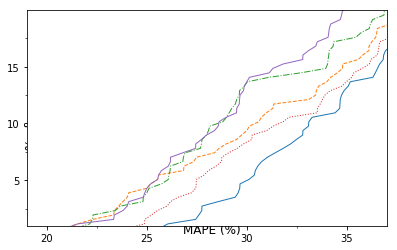

In [155]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
linestyles = ['-','--','-.',':','-']
# create a cdf of the errors
fs = 12
newColors = sns.color_palette()
fig = plt.figure(figsize = (5,3))
ax1 = fig.add_subplot(111)
labZ = []
lines = []

for j in range(5):
    vals = MAPEsIncBest[:,j]
    test = vals[np.argsort(vals)]
    l1, = ax1.plot(100*test,100*np.arange(1,nUsers+1)/np.float(nUsers+1),color=newColors[j], \
                   linestyle = linestyles[j], linewidth=1.)
    lines.append(l1)
    labZ.append('%d load shapes'%(j+1))

ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_ylabel('% of users', fontsize=fs)
ax1.set_xlabel('MAPE (%)', fontsize=fs)
ax1.set_xticks(np.arange(0,100,5),minor=True)
ax1.set_yticks(np.arange(0,100,5),minor=True)
ax1.set_xlim([15,100])
ax1.set_ylim([0,100])
labZ = ['Persist', 'MLR', 'CM1', 'CM2', 'Best']
ax1.legend(lines, labZ, loc='best', frameon=True, fontsize=fs-1);

parent_axis = plt.gca()

ax2 = inset_axes(parent_axis, 1, 1)
ax2.plot([19,37],[2,20])
# hide the ticks of the linked axes
ax2.set_xticks([])
ax2.set_yticks([])

#add a new axes to the plot and plot whatever you like
ax3 = plt.gcf().add_axes([0,0,1,1])
ax3.set_xlim([-1,6])
ax3.set_ylim([-1,6])

ip = InsetPosition(ax1,[0.55,0.14,0.4,0.4])
ax2.set_axes_locator(ip)
# set the new axes (ax3) to the position of the linked axes
ax3.set_axes_locator(ip)
# I want to be able to control where the mark is connected to, independently of the data in the ax2.plot call
mark_inset(ax1, ax2, 2, 4, fc="none", ec='0.5', linewidth=1)


# # These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.55, 0.2, 0.3, 0.3]
# ax2 = fig.add_axes([left, bottom, width, height])
for j in range(5):
    vals = MAPEsIncBest[:,j]
    test = vals[np.argsort(vals)]
    ax3.plot(100*test,100*np.arange(1,nUsers+1)/np.float(nUsers+1),color=newColors[j], \
             linestyle=linestyles[j], linewidth=1.)
ax3.set_xlim([19,37])
ax3.set_ylim([1,20])
ax3.set_yticks(np.arange(5,17,5))
ax3.set_xticks(np.arange(20,37,5))
ax3.set_yticks(np.arange(2.5,18,2.5), minor=True);
ax3.set_xticks(np.arange(20,37,2.5), minor=True);

# fig.savefig('../outputs/errorCdf.png', dpi=300, format='png',  bbox_inches='tight')

[0.55342398 0.5593162  0.53357834 0.53346055 0.50814669]


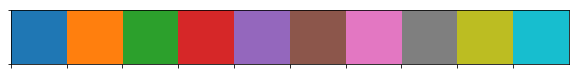

In [156]:
print(np.median(MAPEsIncBest, axis=0))
sns.palplot(newColors)

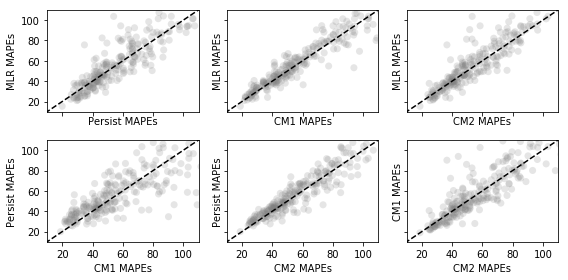

In [157]:
forecastLabs = ['Persist', 'MLR', 'CM1', 'CM2']
forecastLabs = [(f+' MAPEs') for f in forecastLabs]
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
fig, axs = plt.subplots(2,3, figsize=(8,4), facecolor='w', edgecolor='k', sharex='col', sharey='row')
axs = axs.ravel()
toPlot = [[0,1],[2,1],[3,1],[2,0],[3,0],[3,2]] 
for k in range(6):
    x,y = 100*MAPEs[:,toPlot[k][0]],100*MAPEs[:,toPlot[k][1]]
    # print pearsonr(x, y)
    cax = axs[k].scatter(x, y, c='grey', s=50, edgecolor='', alpha=0.2)
    axs[k].set_xlim([10,110])
    axs[k].set_ylim([10,110])
    axs[k].set_xlabel(forecastLabs[toPlot[k][0]])
    axs[k].set_ylabel(forecastLabs[toPlot[k][1]])
    axs[k].plot(np.arange(0,200,1),np.arange(0,200,1),linestyle='--', color='k')
# fig.colorbar(cax)
fig.tight_layout()

In [158]:
print(np.where((MAPEs[:,2]-MAPEs[:,3])>0.7)) # CM1 has more than 70% more error than CM2
print(np.where((MAPEs[:,2]-MAPEs[:,3])<-0.25)) # CM1 has 30% less error than CM2

(array([107, 109, 150, 176]),)
(array([160, 207, 220, 249]),)


In [159]:
# a = np.where((MAPEs[:,2]-MAPEs[:,3])<-0.3)
a = np.where((MAPEs[:,2]-MAPEs[:,3])>0.7)
for j in a[0]:
    print(np.argmin(MAPEs[j,:]))

0
0
0
0


In [160]:
print(startVal, endVal)
print(np.argmin(MAPEs[150,:]))
print(MAPEs[150,:])

0 732
0
[0.38031477 2.7128089  2.8283522  0.4662454 ]


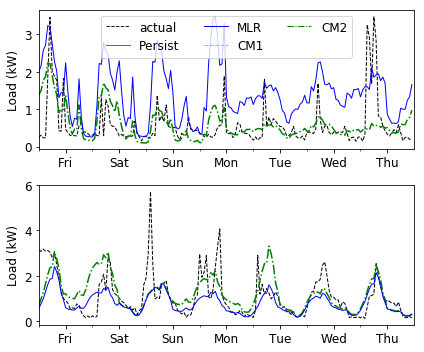

In [161]:
pro = [109,164]
fig = plt.figure(figsize = (6,5))
axs = []

count = 0
for pp in pro:
    if count==0:
        window = [endVal+24*0,endVal+24*7]
    else:
        window = [endVal+24*14,endVal+24*21]
    plotStart, plotEnd = startPred+window[0], startPred+window[1]
    nU = pp # LOOK AT THIS USER
    axs.append(fig.add_subplot(2,1,count+1))

    indexVals = actual.index
    # find the first tick
    j = startPred+window[0]
    for ind in indexVals:
        if j >= plotStart:
            if ind.hour == 0:
                startTick = 0+j
                break
        j+=1

    axs[count].plot(np.arange(plotStart,plotEnd), actualIndividual[nU, window[0]:window[1]],\
                    color='k', linestyle='--', linewidth=1)
#     axs[count].plot(np.arange(plotStart,plotEnd), predQuadraticTempIndividual[nU, window[0]:window[1]], \
#                     color='b', linestyle='-',linewidth=0.6)
    axs[count].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads24Lag[nU, window[0]:window[1]],\
                    color='g', linestyle='-.')
#     axs[count].plot(np.arange(plotStart,plotEnd), seasonalNaive1Individual[nU, window[0]:window[1]], \
#                     color='magenta', linestyle='-',linewidth=0.6)
    axs[count].plot(np.arange(plotStart,plotEnd), clusterPredictedLoadsTemp[nU, window[0]:window[1]],\
                   color='b', linestyle='-',linewidth=1)

    axs[count].set_xlim([plotStart,plotEnd])
    axs[count].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
    axs[count].set_xticks(np.arange(startTick+12,plotEnd,24))
    tickLabs = []
    for ti in np.arange(startTick+12,plotEnd,24):
        tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
    axs[count].set_xticklabels(tickLabs)
    axs[count].tick_params(axis='both', labelsize=12)
    axs[count].set_ylabel('Load (kW)', fontsize=12)
#     axs[count].set_ylim([0,8.5])
    count+=1
    
lineLabels = ['actual','Persist', 'MLR', 'CM1', 'CM2']
linstyles = ['--','-','-','--','-.']
lColors = ['k','magenta','b','cyan','g']
lWid = [0.9,1,1,1,1]
lines = []
for j in range(5):
    line = mlines.Line2D([], [], color=lColors[j], label=lineLabels[j], linestyle=linstyles[j], linewidth=lWid[j])
    lines.append(line)
axs[0].legend(handles=lines, ncol=3, fontsize=12, frameon=True, loc='upper center')
fig.tight_layout()
# fig.savefig('../outputs/comparisonForecasts.png', dpi=300, format='png',  bbox_inches='tight')